In [44]:
!conda list

# packages in environment at C:\Users\foxir\miniconda3\envs\gunshot_tf:
#
# Name                    Version                   Build  Channel
absl-py                   2.1.0                    pypi_0    pypi
annotated-types           0.7.0                    pypi_0    pypi
appdirs                   1.4.4                    pypi_0    pypi
asttokens                 3.0.0                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
audiomentations           0.38.0                   pypi_0    pypi
audioread                 3.0.1                    pypi_0    pypi
bzip2                     1.0.8                h2466b09_7    conda-forge
ca-certificates           2024.12.14           h56e8100_0    conda-forge
cachetools                5.5.0                    pypi_0    pypi
certifi                   2024.12.14               pypi_0    pypi
cffi                      1.17.1                   pypi_0    pypi
charset-normalizer        3.4.0                    py

In [167]:
%conda install pandas=2.2.2 

Retrieving notices: done
Channels:
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\foxir\miniconda3\envs\gunshot_tf

  added / updated specs:
    - pandas=2.2.2


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bottleneck-1.4.2           |  py310hc99e966_0         130 KB
    numexpr-2.10.1             |  py310h4cd664f_0         176 KB
    pandas-2.2.2               |  py310h5da7b33_0        12.0 MB
    python-tzdata-2023.3       |     pyhd3eb1b0_0         140 KB
    ------------------------------------------------------------
                                           Total:        12.5 MB

The following NEW packages will be INSTALLED:

  blas               pkgs/main/win-64::blas-1.0-mkl 
  bottleneck         pkgs/main/win-64::bottleneck-1.4.2-py310hc99e966_0 
  intel-openmp       pkgs/main/win-64::

C:\Users\foxir\miniconda3\Lib\site-packages\conda\base\context.py:200: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(


In [168]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
import pandas as pd
import glob
import random
import csv

In [2]:
from audiomentations import Compose, Gain, AddGaussianNoise, TimeMask, AddShortNoises, PolarityInversion

In [3]:
!python -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
def load_wav_8k_mono(filename):
    try:
        file_contents = tf.io.read_file(filename)
        wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        if sample_rate != 8000:
            wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=8000)
        wav = tf.squeeze(wav, axis=-1)
    except Exception as e:
        print(f"Invalid file: {filename} - {e}")
    return wav

In [5]:
sample_rate = 8000
mel_spec_length = 32000
frame_length = 256
frame_step = 128
mel_bins = 64
upper_edge = 4000
lower_edge = 0

In [6]:
def preprocess_mel(file_path, label):
    # load wav and make sure length is proper
    if isinstance(file_path, str):
        try:
            wav, label = load_wav_8k_mono(file_path)
        except Exception as e:
            print(f"Failed to load wav file at {file_path} - {e}")
    else:
        wav = file_path

    if len(wav) > 32000:
        wav = wav[:mel_spec_length]
    if len(wav) < 32000:
        try:
            zero_padding = tf.zeros([mel_spec_length] - tf.shape(wav), dtype=tf.float32)
            wav = tf.concat([zero_padding, wav], 0)
        except Exception as e:
            print(f"Failed to pad wav file at {file_path} - {e}")
    
    # create the spectrogram
    print("Wav Shape:", wav.shape)
    spectrogram = tf.signal.stft(wav, frame_length, frame_step, window_fn=tf.signal.hann_window)
    print("STFT Shape1:", spectrogram.shape)
    spectrogram = tf.abs(spectrogram)
    print("STFT Shape2:", spectrogram.shape)

    # create the mel filterbank
    spec_bins = frame_length // 2 + 1  # Derived from frame length
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        mel_bins,
        spec_bins,
        sample_rate,
        lower_edge,
        upper_edge,
    )
    print("Mel Filterbank Shape:", mel_filterbank.shape)
    
    # create the mel spectrogram
    mel_spectrogram = tf.matmul(spectrogram, mel_filterbank)
    print("Mel Spectrogram Shape1:", mel_spectrogram.shape)

    # add a dimension
    mel_spectrogram = tf.expand_dims(mel_spectrogram, axis=2)
    print("Mel Spectrogram Shape2:", mel_spectrogram.shape)

    return mel_spectrogram, label

In [149]:
augment_pos = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeMask(min_band_part=0.05, max_band_part=0.08, p=0.0),
    AddShortNoises(sounds_path=train_NEG,
                   min_snr_db=3.0, max_snr_db=30.0,
                   noise_rms="relative_to_whole_input",
                   min_time_between_sounds=2.0,
                   max_time_between_sounds=8.0,
                   noise_transform=PolarityInversion(),
                   p=0.5
                  ),
])

In [150]:
augment_neg = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    Gain(min_gain_db=-6.0, max_gain_db=6.0, p=0.5),
    TimeMask(min_band_part=0.05, max_band_part=0.08, p=0.0),
    AddShortNoises(sounds_path=train_NEG,
                   min_snr_db=3.0, max_snr_db=30.0,
                   noise_rms="relative_to_whole_input",
                   min_time_between_sounds=2.0,
                   max_time_between_sounds=8.0,
                   noise_transform=PolarityInversion(),
                   p=0.5
                  ),
])

In [11]:
augment_val = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.0),
])

In [12]:
def augment_pos_wav(wav_tensor):
    # wav_numpy = wav_tensor.numpy()
    augmented_wav = augment_pos(samples=wav_tensor, sample_rate=8000)
    augmented_wav = tf.convert_to_tensor(augmented_wav, dtype=tf.float32)
    return augmented_wav

In [13]:
def augment_neg_wav(wav_tensor):
    # wav_numpy = wav_tensor.numpy()
    augmented_wav = augment_neg(samples=wav_tensor, sample_rate=8000)
    augmented_wav = tf.convert_to_tensor(augmented_wav, dtype=tf.float32)
    return augmented_wav

In [14]:
def augment_val_wav(wav_tensor):
    # wav_numpy = wav_tensor.numpy()
    augmented_wav = augment_val(samples=wav_tensor, sample_rate=8000)
    augmented_wav = tf.convert_to_tensor(augmented_wav, dtype=tf.float32)
    return augmented_wav

In [15]:
def load_and_augment_pos_wav_tf(filename):
    # Loads and augments gunshot wavs with tensorflow, calling respective audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_pos_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav

In [16]:
def load_and_augment_neg_wav_tf(filename):
    # Loads and augments background wavs with tensorflow, calling respective audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_neg_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav

In [17]:
def load_and_augment_val_wav_tf(filename):
    # Loads and augments val wavs with tensorflow, calling zero audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_val_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav

In [120]:
def load_and_augment_val_wav_tf_tuple(filename, label):
    # Loads and augments val wavs with tensorflow, calling zero audiomentation functions
    wav = load_wav_8k_mono(filename)
    augmented_wav = tf.numpy_function(func=augment_val_wav, inp=[wav], Tout=tf.float32)
    return augmented_wav, label

In [36]:
28790+7190

7190/35980

0.19983324068927183

In [24]:
b_val_NEG = os.path.join('belize-data', 'Validation data', 'Background')
b_val_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
b_train_NEG = os.path.join('belize-data', 'Training data', 'Background')
b_train_POS = os.path.join('belize-data', 'Training data', 'Gunshot')
'''
v_test_NEG = os.path.join('belize-data', 'Validation data', 'Background')
v_test_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
v_test_NEG = os.path.join('belize-data', 'Validation data', 'Background')
v_test_POS = os.path.join('belize-data', 'Validation data', 'Gunshot')
v_train_NEG = os.path.join('belize-data', 'Training data', 'Background')
v_train_POS = os.path.join('belize-data', 'Training data', 'Gunshot')
'''
model_save_dir = os.path.join('model','model_exports')

In [101]:
b_val_neg = glob.glob(b_val_NEG+'/*.wav')
b_val_pos = glob.glob(b_val_POS+'/*.wav')

print("Amount of negatives:", len(b_val_neg))
print("Amount of positives:", len(b_val_pos))

b_val_neg = list(zip(b_val_neg, [0]*len(b_val_neg)))
b_val_pos = list(zip(b_val_pos, [1]*len(b_val_pos)))

b_val = b_val_neg+b_val_pos
random.shuffle(b_val)
b_test = b_val[:3595]
b_val = b_val[3595:]

Amount of negatives: 7040
Amount of positives: 150


In [71]:
b_test

[('belize-data\\Validation data\\Background\\5AEF377F.WAV', 0),
 ('belize-data\\Validation data\\Background\\5AD6225C.WAV', 0),
 ('belize-data\\Validation data\\Background\\5AF73C93.WAV', 0),
 ('belize-data\\Validation data\\Background\\5ACD22A9.WAV', 0),
 ('belize-data\\Validation data\\Background\\601EEF25.WAV', 0),
 ('belize-data\\Validation data\\Background\\5AD3625A.WAV', 0),
 ('belize-data\\Validation data\\Background\\5B059E2F.WAV', 0),
 ('belize-data\\Validation data\\Background\\5AD14307.WAV', 0),
 ('belize-data\\Validation data\\Background\\60188399.WAV', 0),
 ('belize-data\\Validation data\\Background\\5B1AD845.WAV', 0),
 ('belize-data\\Validation data\\Background\\5B0D4E50.WAV', 0),
 ('belize-data\\Validation data\\Background\\5B103682.WAV', 0),
 ('belize-data\\Validation data\\Background\\5AF77941.WAV', 0),
 ('belize-data\\Validation data\\Background\\5AD1F60C.WAV', 0),
 ('belize-data\\Validation data\\Background\\5ADE66D3.WAV', 0),
 ('belize-data\\Validation data\\Backgro

In [106]:
b_test_files_2 = []
for filename, label in b_test:
    filename = filename
    label = label
    element = [filename, label]
    b_test_files_2.append(element)

In [172]:
b_val_files = []
for filename, label in b_val:
    filename = filename
    label = label
    element = [filename, label]
    b_val_files.append(element)

In [173]:
b_val_files

[['belize-data\\Validation data\\Background\\601E4DCA.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AE8919F.WAV', 0],
 ['belize-data\\Validation data\\Background\\600A271A.WAV', 0],
 ['belize-data\\Validation data\\Background\\60141537.WAV', 0],
 ['belize-data\\Validation data\\Background\\600F2711.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B159B99.WAV', 0],
 ['belize-data\\Validation data\\Background\\601F69A8.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B0E35ED.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B09D4FE.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B0DED53.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AEB8C96.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AFE183A.WAV', 0],
 ['belize-data\\Validation data\\Background\\60213670.WAV', 0],
 ['belize-data\\Validation data\\Background\\600F5013.WAV', 0],
 ['belize-data\\Validation data\\Background\\5ADF3B18.WAV', 0],
 ['belize-data\\Validation data\\Backgro

In [105]:
b_test_files

['belize-data\\Validation data\\Background\\5B105024.WAV',
 0,
 'belize-data\\Validation data\\Background\\601060F2.WAV',
 0,
 'belize-data\\Validation data\\Background\\5B1209C1.WAV',
 0,
 'belize-data\\Validation data\\Background\\5AE63AB2.WAV',
 0,
 'belize-data\\Validation data\\Background\\600FF645.WAV',
 0,
 'belize-data\\Validation data\\Background\\5B01D75F.WAV',
 0,
 'belize-data\\Validation data\\Background\\5AFDC674.WAV',
 0,
 'belize-data\\Validation data\\Background\\5AEF7BE0.WAV',
 0,
 'belize-data\\Validation data\\Background\\60195DFC.WAV',
 0,
 'belize-data\\Validation data\\Background\\5AEEF534.WAV',
 0,
 'belize-data\\Validation data\\Background\\5ACCD6D3.WAV',
 0,
 'belize-data\\Validation data\\Background\\5B1565EF.WAV',
 0,
 'belize-data\\Validation data\\Background\\5B0F6933.WAV',
 0,
 'belize-data\\Validation data\\Background\\5AE3B46F.WAV',
 0,
 'belize-data\\Validation data\\Background\\601B25E2.WAV',
 0,
 'belize-data\\Validation data\\Background\\601EACB6.WA

In [163]:
b_test_files_2

[['belize-data\\Validation data\\Background\\5B105024.WAV', 0],
 ['belize-data\\Validation data\\Background\\601060F2.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B1209C1.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AE63AB2.WAV', 0],
 ['belize-data\\Validation data\\Background\\600FF645.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B01D75F.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AFDC674.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AEF7BE0.WAV', 0],
 ['belize-data\\Validation data\\Background\\60195DFC.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AEEF534.WAV', 0],
 ['belize-data\\Validation data\\Background\\5ACCD6D3.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B1565EF.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B0F6933.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AE3B46F.WAV', 0],
 ['belize-data\\Validation data\\Background\\601B25E2.WAV', 0],
 ['belize-data\\Validation data\\Backgro

In [108]:
b_test_files = b_test_files_2
b_test_files

[['belize-data\\Validation data\\Background\\5B105024.WAV', 0],
 ['belize-data\\Validation data\\Background\\601060F2.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B1209C1.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AE63AB2.WAV', 0],
 ['belize-data\\Validation data\\Background\\600FF645.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B01D75F.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AFDC674.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AEF7BE0.WAV', 0],
 ['belize-data\\Validation data\\Background\\60195DFC.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AEEF534.WAV', 0],
 ['belize-data\\Validation data\\Background\\5ACCD6D3.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B1565EF.WAV', 0],
 ['belize-data\\Validation data\\Background\\5B0F6933.WAV', 0],
 ['belize-data\\Validation data\\Background\\5AE3B46F.WAV', 0],
 ['belize-data\\Validation data\\Background\\601B25E2.WAV', 0],
 ['belize-data\\Validation data\\Backgro

In [138]:
b_test_files = np.array(b_test_files)
filenames = b_test_files[:,0]
labels = b_test_files[:,1].astype(int)
for label in labels:
    label = tf.cast(label, tf.float32)

In [139]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [140]:
b_test = tf.data.Dataset.from_tensor_slices((filenames, labels))
for item in b_test.take(3):
    print(item)

(<tf.Tensor: shape=(), dtype=string, numpy=b'belize-data\\Validation data\\Background\\5B105024.WAV'>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'belize-data\\Validation data\\Background\\601060F2.WAV'>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'belize-data\\Validation data\\Background\\5B1209C1.WAV'>, <tf.Tensor: shape=(), dtype=int32, numpy=0>)


In [129]:
def change_label_type(filename, label):
    label = tf.cast(label, tf.float32)
    return filename, label

In [141]:
b_test = b_test.map(load_and_augment_val_wav_tf_tuple)
b_test = b_test.map(change_label_type)
b_test = b_test.map(preprocess_mel)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [159]:
b_test

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [152]:
train_data

<ConcatenateDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [ ]:
for spectrogram, label in b_test.take(3):
    item = spectrogram
    print(label)
    plt.figure(figsize=(30,20))
    plt.imshow(tf.transpose(item)[0])
    plt.colorbar(label="Amplitude")
    plt.title("Test of a prepared spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.show()

In [174]:
p=0
n=0
for filename, label in b_val:
    if label==1:
        n=n
        p=p+1
    else:
        p=p
        n=n+1
print(p)
print(n)

75
3520


In [164]:
p=0
n=0
for filename, label in b_test_files_2:
    if label==1:
        n=n
        p=p+1
    else:
        p=p
        n=n+1
print(p)
print(n)

75
3520


In [175]:
df_to_csv = pd.DataFrame(b_val_files, columns=['filename', 'label'])

output_file = 'b_val_files_and_labels.csv'
df_to_csv.to_csv(output_file, index=False)

In [33]:
b_val_neg = tf.data.Dataset.list_files(b_val_NEG+'/*.wav')
b_val_neg = tf.data.Dataset.zip((b_val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(b_val_neg)))))
b_val_pos = tf.data.Dataset.list_files(b_val_POS+'/*.wav')
b_val_pos = tf.data.Dataset.zip((b_val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(b_val_pos)))))

b_val_pos = tf.data.Dataset.list_files(b_val_POS+'/*.wav')
b_val = b_val_pos.concatenate(b_val_neg)

TypeError: Incompatible dataset elements:
  TensorSpec(shape=(), dtype=tf.string, name=None) vs.   (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))

In [ ]:
b_train_pos = tf.data.Dataset.list_files(b_train_POS+'/*.wav')
b_train_neg = tf.data.Dataset.list_files(b_train_NEG+'/*.wav')
v_train_pos = tf.data.Dataset.list_files(b_train_NEG+'/*.wav')
v_train_neg = tf.data.Dataset.list_files(b_train_NEG+'/*.wav')

train_pos = b_train_pos.concatenate(v_train_pos)
train_neg = b_train_neg.concatenate(v_train_neg)

train_pos = train_pos.map(load_and_augment_pos_wav_tf)
train_pos = tf.data.Dataset.zip((train_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(train_pos)))))
train_pos = train_pos.map(preprocess_mel)

train_neg = train_neg.map(load_and_augment_neg_wav_tf)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_mel)

train_data = train_pos.concatenate(train_neg)

In [151]:
train_pos = tf.data.Dataset.list_files(train_POS+'/*.wav')
train_pos = train_pos.map(load_and_augment_pos_wav_tf)
train_pos = tf.data.Dataset.zip((train_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(train_pos)))))
train_pos = train_pos.map(preprocess_mel)

train_neg = tf.data.Dataset.list_files(train_NEG+'/*.wav')
train_neg = train_neg.map(load_and_augment_neg_wav_tf)
train_neg = tf.data.Dataset.zip((train_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(train_neg)))))
train_neg = train_neg.map(preprocess_mel)

train_data = train_pos.concatenate(train_neg)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [127]:
val_pos = tf.data.Dataset.list_files(val_POS+'/*.wav')
val_pos = val_pos.map(load_and_augment_val_wav_tf)
val_pos = tf.data.Dataset.zip((val_pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(val_pos)))))
val_pos = val_pos.map(preprocess_mel)

val_neg = tf.data.Dataset.list_files(val_NEG+'/*.wav')
val_neg = val_neg.map(load_and_augment_val_wav_tf)
val_neg = tf.data.Dataset.zip((val_neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(val_neg)))))
val_neg = val_neg.map(preprocess_mel)

val_data = val_pos.concatenate(val_neg)

Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>
Wav Shape: <unknown>
STFT Shape1: <unknown>
STFT Shape2: <unknown>
Mel Filterbank Shape: (129, 64)
Mel Spectrogram Shape1: <unknown>
Mel Spectrogram Shape2: <unknown>


In [155]:
len(train_data)

28790

In [156]:
data = train_data
data = data.cache()
data = data.shuffle(buffer_size=28791)
data = data.batch(16)
data = data.prefetch(8)

In [23]:
train = data.take(36)
test = data.skip(36).take(15)
samples, labels = train.as_numpy_iterator().next()

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Recall, Precision, Accuracy
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.regularizers import l2

In [43]:
def my_model():
    inputs = keras.Input(shape=(249,64,1))
    
    x = layers.Conv2D(16, (3,3))(inputs)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(24, (3,3))(x)
    x = keras.activations.relu(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    outputs = layers.Dropout(0.3)(outputs)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=False),metrics=[Recall(), Precision(), Accuracy()])

    return model

model = my_model()
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 249, 64, 1)]      0         
                                                                 
 conv2d_22 (Conv2D)          (None, 247, 62, 16)       160       
                                                                 
 tf.nn.relu_14 (TFOpLambda)  (None, 247, 62, 16)       0         
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 123, 31, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 121, 29, 24)       3480      
                                                                 
 tf.nn.relu_15 (TFOpLambda)  (None, 121, 29, 24)       0         
                                                           

In [26]:
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 247, 62, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 245, 60, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 235200)            0         
                                                                 
 dense (Dense)               (None, 128)               30105728  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 30,108,337
Trainable params: 30,108,337
Non-trainable params: 0
_________________________________________________________________


In [32]:
model=Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(249, 64, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(24, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.05)))
model.add(Dropout(0.3))

model.compile('Adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),tf.keras.metrics.Accuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 247, 62, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 31, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 121, 29, 24)       3480      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 14, 24)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 60, 14, 24)        0         
                                                                 
 flatten (Flatten)           (None, 20160)             0

In [27]:
hist = model.fit(train, epochs=20, validation_data=test)

Epoch 1/20
36/36 [==============================] - 51s 1s/step - loss: 0.8182 - recall: 0.4824 - precision: 0.5829 - val_loss: 0.5709 - val_recall: 0.2879 - val_precision: 0.5938
Epoch 2/20
36/36 [==============================] - 30s 666ms/step - loss: 0.6199 - recall: 0.3127 - precision: 0.7168 - val_loss: 0.5859 - val_recall: 0.3333 - val_precision: 0.5500
Epoch 3/20
36/36 [==============================] - 28s 576ms/step - loss: 0.5654 - recall: 0.6007 - precision: 0.7488 - val_loss: 0.4526 - val_recall: 0.5316 - val_precision: 0.8571
Epoch 4/20
36/36 [==============================] - 24s 529ms/step - loss: 0.5356 - recall: 0.6364 - precision: 0.7285 - val_loss: 0.5351 - val_recall: 0.6143 - val_precision: 0.7288
Epoch 5/20
36/36 [==============================] - 23s 469ms/step - loss: 0.5156 - recall: 0.7293 - precision: 0.7239 - val_loss: 0.3988 - val_recall: 0.4677 - val_precision: 0.8529
Epoch 6/20
36/36 [==============================] - 21s 446ms/step - loss: 0.4673 - reca

In [93]:
hist.history

{'loss': [0.0199140515178442,
  8.229680949499952e-34,
  8.083626694765245e-35,
  2.907081329473761e-34],
 'recall_1': [0.9722222089767456, 1.0, 1.0, 1.0],
 'precision_1': [1.0, 1.0, 1.0, 1.0],
 'val_loss': [6.168291811569756e-34,
  1.4702901050212623e-37,
  2.0649835505512273e-35,
  1.7371968360300622e-35],
 'val_recall_1': [1.0, 1.0, 1.0, 1.0],
 'val_precision_1': [1.0, 1.0, 1.0, 1.0]}

<function matplotlib.pyplot.show(close=None, block=None)>

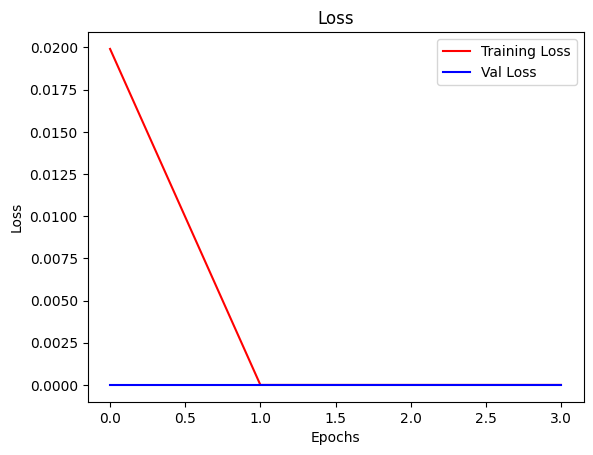

In [94]:
plt.title('Loss')
plt.plot((hist.history['loss']), 'r', label='Training Loss')
plt.plot((hist.history['val_loss']), 'b', label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

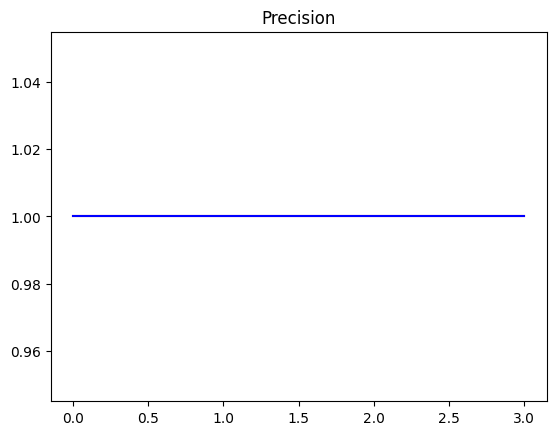

In [96]:
plt.title('Precision')
plt.plot((hist.history['precision_1']), 'r', label='Training Precision')
plt.plot((hist.history['val_precision_1']), 'b', label='Val Precision')

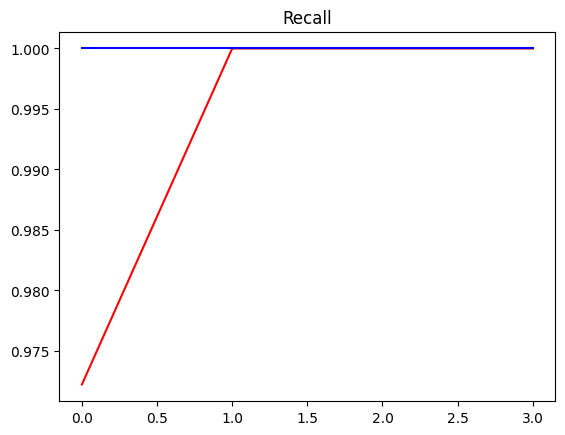

In [97]:
plt.title('Recall')
plt.plot(hist.history['recall_1'], 'r', label='Training Recall')
plt.plot(hist.history['val_recall_1'], 'b', label='Val Recall')
plt.show()

In [28]:
model.save('9-22PM,1-12-25,B-Dataset,30mPara,20E.keras', 'model_save_dir')